In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
X, y = make_moons(n_samples=1000, random_state=42)

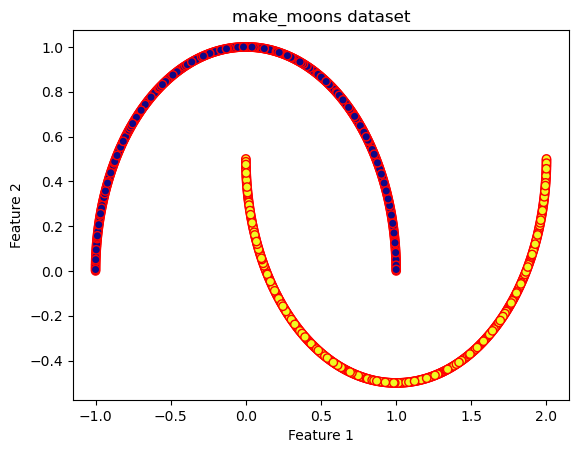

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', edgecolor='r')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons dataset')
plt.show()

In [10]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
device = torch.device('mps' if torch.mps.is_available else 'cpu')
device

device(type='mps')

In [13]:
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
X_train = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)

/var/folders/_2/_yhjp4h153l3658w2fh53v580000gn/T/ipykernel_20345/1641537016.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_test, dtype=torch.float).to(device)
